In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
import deepinv as dinv
from tqdm import tqdm
from ProxNest.sampling import resampling
import ProxNest as pxn


# Load image

In [2]:
# import torchvision
# from PIL import Image

In [3]:


# Load Image
dim = 64
x_true = np.load('../../data/butterfly_{}.npy'.format(dim))

# Normalise magnitude
x_true -= np.nanmin(x_true)
x_true /= np.nanmax(x_true)
x_true[x_true<0] = 0

# To pytorch
x_true = torch.Tensor(x_true).to(device)
x = x_true.clone().to(device)


In [4]:

# formatted = (x_true * 255 / np.max(x_true)).astype('uint8')[0,:,:,:]
# print(formatted.shape)
# img = Image.fromarray(np.moveaxis(formatted, 0, 2))
# x_true = torchvision.transforms.functional.to_grayscale(img, num_output_channels=1)


## Define model and generate observations

In [5]:
# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(x_true.cpu().numpy())**2)) * 10**(-ISNR/20)

print('sigma*255: ', sigma*255)
# Define the forward operator
blur_kernel_size = 3

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones(
        (1, 1, blur_kernel_size, blur_kernel_size),
        device=device
    ) / blur_kernel_size**2,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)

# Compute observations
y = physics(x)



sigma*255:  15.78251999616623


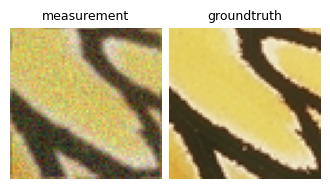

In [6]:
# Plot observations and true x

imgs = [y, x_true]
titles=["measurement", "groundtruth"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)

## Define parameters and initialise denoising model

In [7]:
# Options dictionary associated with the overall sampling algorithm
options = {
    'samplesL': 1e1,        # Number of live samples
    'samplesD': 2e1,      # Number of discarded samples 
       'sigma': sigma,      # Noise standard deviation of degraded image
        'tol' : 1e-10,      # Convergence tolerance of algorithm (Ball projection alg)
   'max_iter' : 500,        # Maximum number of iterations (Ball projection alg)
    'verbose' : True,       # Verbosity
}

diff_params = {
         'model_type' : 'imagenet',     # Type of pretrained model. Options are 'imagenet' or 'ffhq'
        'in_channels' : 3,              # Channels in the input Tensor.
       'out_channels' : 3,              # Channels in the output Tensor.
        'sigma_noise' : sigma,          # Noise standard deviation of degraded image
    'diffusion_steps' : 100,            # Maximum number of iterations of the DiffPIR algorithm
            'lambda_' : 7.0,            # Regularisation parameter
               'zeta' : 0.5,            # DiffPIR parameter controling the diffusion
}


# Gaussian log likelihood
LogLikeliL = lambda x_current, y, physics, sigma : - torch.nn.functional.mse_loss(
    y,
    physics.A(x_current), # Apply the forward model (without the noise addition)
    reduction='sum'
) / (2*sigma**2)

LikeliL = LogLikeliL

# Load the denoiser for the diffusion model 
if diff_params['model_type'] == 'imagenet':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
    large_model = True
elif diff_params['model_type'] == 'ffhq':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
    large_model = False

denoising_model = dinv.models.DiffUNet(
    in_channels=diff_params['in_channels'],
    out_channels=diff_params['out_channels'],
    pretrained=model_path,
    large_model=large_model
).to(device)



## Init model

In [8]:
x_init = physics.A_adjoint(y)

In [9]:


diffnest = pxn.sampling.diff_nested.DiffusionNestedSampling(
    x_init=x_init,
    y=y,
    denoising_model=denoising_model,
    physics=physics,
    LogLikeliL=LogLikeliL,
    options=options,
    diff_params=diff_params,
    device=device
)



In [10]:
# Run
BayEvi, Xtrace = diffnest.run()


DiffNest || Populate: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]
DiffNest || Sample:   0%|          | 0/20 [00:00<?, ?it/s]

Using init sample to start diffusion


DiffNest || Sample:   5%|▌         | 1/20 [00:09<03:07,  9.89s/it]

Using init sample to start diffusion


DiffNest || Sample:  10%|█         | 2/20 [00:19<02:52,  9.61s/it]

Using init sample to start diffusion


DiffNest || Sample:  15%|█▌        | 3/20 [00:28<02:43,  9.63s/it]

Using init sample to start diffusion


DiffNest || Sample:  20%|██        | 4/20 [00:38<02:36,  9.78s/it]

Using init sample to start diffusion


DiffNest || Sample:  25%|██▌       | 5/20 [00:48<02:28,  9.87s/it]

Using init sample to start diffusion


DiffNest || Sample:  30%|███       | 6/20 [00:58<02:17,  9.80s/it]

Using init sample to start diffusion


DiffNest || Sample:  35%|███▌      | 7/20 [01:07<02:04,  9.54s/it]

Using init sample to start diffusion


DiffNest || Sample:  40%|████      | 8/20 [01:16<01:51,  9.26s/it]

Using init sample to start diffusion


DiffNest || Sample:  45%|████▌     | 9/20 [01:26<01:44,  9.46s/it]

Using init sample to start diffusion


DiffNest || Sample:  50%|█████     | 10/20 [01:35<01:34,  9.44s/it]

Using init sample to start diffusion


DiffNest || Sample:  55%|█████▌    | 11/20 [01:45<01:25,  9.48s/it]

Using init sample to start diffusion


DiffNest || Sample:  60%|██████    | 12/20 [01:53<01:14,  9.26s/it]

Using init sample to start diffusion


DiffNest || Sample:  65%|██████▌   | 13/20 [02:03<01:04,  9.28s/it]

Using init sample to start diffusion


DiffNest || Sample:  70%|███████   | 14/20 [02:12<00:55,  9.29s/it]

Using init sample to start diffusion


DiffNest || Sample:  75%|███████▌  | 15/20 [02:21<00:46,  9.26s/it]

Using init sample to start diffusion


DiffNest || Sample:  80%|████████  | 16/20 [02:30<00:36,  9.14s/it]

Using init sample to start diffusion


DiffNest || Sample:  85%|████████▌ | 17/20 [02:39<00:27,  9.10s/it]

Using init sample to start diffusion


DiffNest || Sample:  90%|█████████ | 18/20 [02:49<00:18,  9.22s/it]

Using init sample to start diffusion


DiffNest || Sample:  95%|█████████▌| 19/20 [02:57<00:09,  9.08s/it]

Using init sample to start diffusion


DiffNest || Sample: 100%|██████████| 20/20 [03:06<00:00,  9.34s/it]
DiffNest || Compute Weights: 100%|██████████| 20/20 [00:00<00:00, 221335.30it/s]
DiffNest || Trapezium Integrate: 100%|██████████| 18/18 [00:00<00:00, 361231.92it/s]
ProxNest || Estimate Variance: 100%|██████████| 20/20 [00:00<00:00, 186000.18it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 20/20 [00:00<00:00, 195995.51it/s]


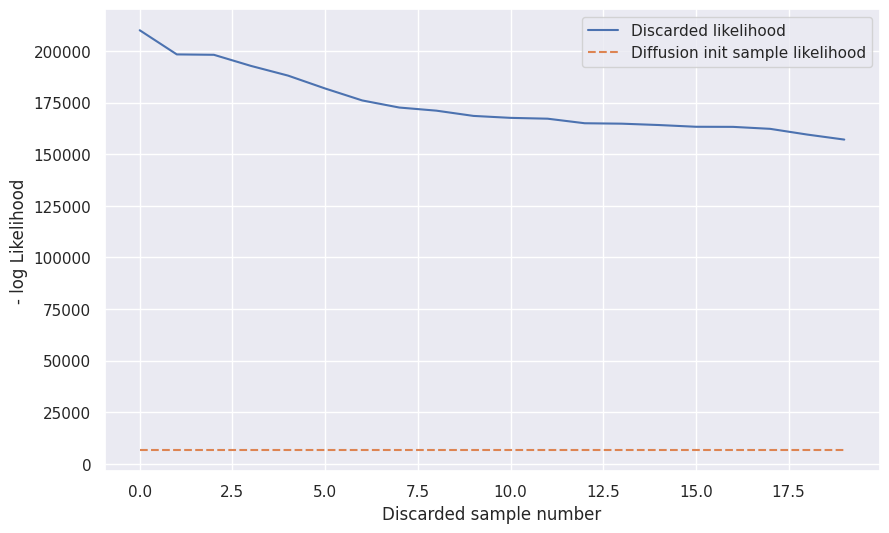

In [33]:
plt.figure(figsize=(10,6))
plt.plot(-Xtrace["DiscardL"], label='Discarded likelihood')
plt.plot(- np.ones_like(Xtrace["DiscardL"]) * diffnest.x_sample_init_logLikeL, '--', label='Diffusion init sample likelihood')
plt.legend()
plt.xlabel('Discarded sample number')
plt.ylabel('- log Likelihood')
plt.savefig('/disk/xray0/tl3/project-nested-diffusion/proxnest/dev/tmp_storage/' + 'likelihood_evolution.pdf')
plt.show()


In [12]:
BayEvi

array([-1.5711291e+05,  6.5581392e-01])

In [16]:
diffnest.x_sample_init_logLikeL

array(-6636.859, dtype=float32)

In [21]:

save_dict = {
    'BayEvi': BayEvi,
    'Xtrace': Xtrace,
}

In [22]:

np.save(
    '/disk/xray0/tl3/project-nested-diffusion/proxnest/dev/tmp_storage/diffnest.npy',
    save_dict,
    allow_pickle=True
)


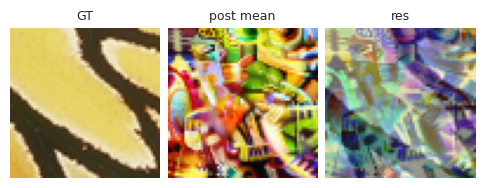

In [26]:
imgs = [x_true, Xtrace["DiscardPostMean"], x_true-Xtrace["DiscardPostMean"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)


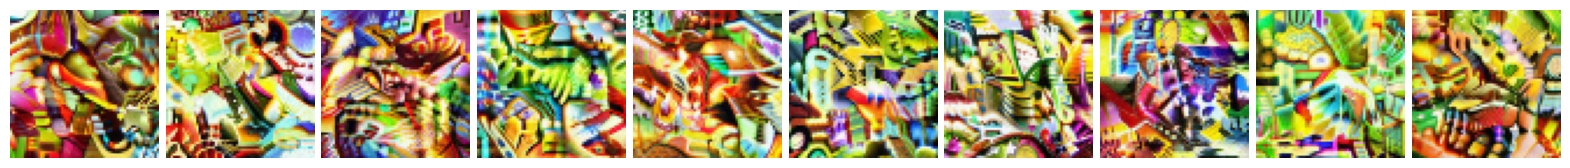

In [14]:
imgs = [_x for _x in Xtrace["Discard"][:10]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)

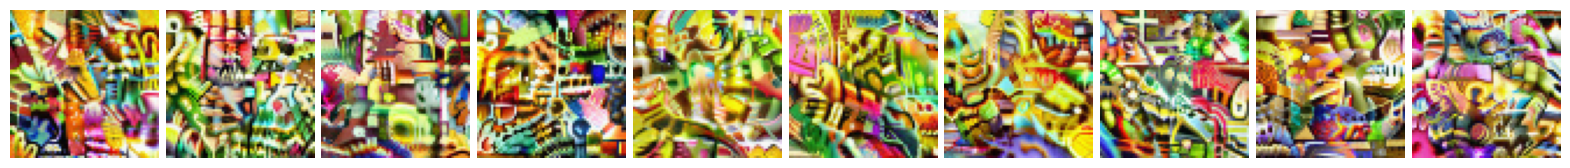

In [15]:
imgs = [_x for _x in Xtrace["LiveSet"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)